In [ ]:
# importing necessary libraries

import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import os
import tqdm, time

import glob
import random,time

import math

from functools import partial

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tensorflow.keras.utils import *
from tensorflow.keras.regularizers import *
import matplotlib.pyplot as plt


from keras.datasets import cifar10

from keras.callbacks import EarlyStopping

## Data loading and preprocessing

In [2]:
# Data Loading and Splitting

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

val_split = 0.1

val_indices = int(len(x_train) * val_split)

new_x_train, new_y_train = x_train[val_indices:], y_train[val_indices:]


x_val, y_val = x_train[:val_indices], y_train[:val_indices]


print(f"Training data samples: {len(new_x_train)}")
print(f"Validation data samples: {len(x_val)}")
print(f"Test data samples: {len(x_test)}")

170498071/170498071 [==============================] - 6s 0us/step
Training data samples: 45000
Validation data samples: 5000
Test data samples: 10000


In [3]:
print('total number of samples: ', len(x_train))
print('number of training samples: ', len(new_x_train))
print('number of validation samples: ', len(x_val))
print('number of validation samples: ', len(x_test))

total number of samples:  50000
number of training samples:  45000
number of validation samples:  5000
number of validation samples:  10000


**Normalization**

In [4]:
new_x_train_nor = new_x_train/255
x_val_nor  = x_val/255
x_test_nor = x_test/255

In [5]:
# Encoding Categories

to_categorical = tf.keras.utils.to_categorical

total_class = len(np.unique(new_y_train))

new_y_train_hot = to_categorical( new_y_train, total_class)

y_val_hot  = to_categorical( y_val, total_class)

y_test_hot = to_categorical( y_test, total_class)

In [6]:
ijd = 100

print(new_y_train[ijd], new_y_train_hot[ijd])

[5] [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [7]:

indx = [i for i in range(0, len(new_x_train_nor))]

random.shuffle(indx)

In [8]:
# Taking a small portion of the dataset

new_y_train_hot_1 =  []
new_x_train_nor_1 = []

small_f = 5000 # allocated length of the dataset
for i in range(small_f):
    new_x_train_nor_1.append(new_x_train_nor[indx[i]] )
    new_y_train_hot_1.append(new_y_train_hot[indx[i]] )


new_y_train_hot_1 = np.array(new_y_train_hot_1)
new_x_train_nor_1 = np.array(new_x_train_nor_1)

In [9]:
print('length of training samples: ', len(new_x_train_nor_1))
print('length of validation samples: ', len(x_val_nor))
print('length of testing samples: ', len(x_test_nor))

length of training samples:  5000
length of validation samples:  5000
length of testing samples:  10000


In [10]:
batch_size = 32
auto = tf.data.AUTOTUNE

def make_datasets(images, labels):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    dataset = dataset.shuffle(50000)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(auto)

train_set =   make_datasets(new_x_train_nor_1, new_y_train_hot_1)
val_set =   make_datasets(x_val_nor, y_val_hot)
test_set =  make_datasets(x_test_nor, y_test_hot )

In [11]:
str_1,str_2 = next(iter(train_set))
stv_1,stv_2 = next(iter(val_set))
sts_1,sts_2 = next(iter(test_set))

print('train, val, test batches', str_1.shape,str_2.shape,stv_1.shape,stv_2.shape,sts_1.shape,sts_2.shape )

train, val, test batches (32, 32, 32, 3) (32, 10) (32, 32, 32, 3) (32, 10) (32, 32, 32, 3) (32, 10)


## model building

In [77]:
filters=64
s_krnl=3
dropout = 0.3
strd = 2
pool = 2

n_classes = 10

inputs = Input(shape=(32, 32, 3))

filter_set = [filters, filters*2, filters*2, filters]

y = inputs


y = Conv2D(filters=filters, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(y)
y = keras.activations.selu(y)
y = Conv2D(filters=filters*2, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(y)
# y = keras.activations.selu(y)
# y = Conv2D(filters=filters*4, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(y)
y = BatchNormalization()(y)
y = LeakyReLU()(y)
y = Dropout(0.1)(y)
y = MaxPooling2D()(y)

y = Conv2D(filters=filters, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(y)
y = keras.activations.elu(y)
y = Conv2D(filters=filters*2, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(y)
# y = keras.activations.elu(y)
# y = Conv2D(filters=filters*4, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(y)
y = BatchNormalization()(y)
y = LeakyReLU()(y)
y = Dropout(0.125)(y)
y = MaxPooling2D()(y)


y = Conv2D(filters=filters, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(y)
y = keras.activations.elu(y)
y = Conv2D(filters=filters, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(y)
y = BatchNormalization()(y)
y = LeakyReLU()(y)
y = Dropout(0.15)(y)
y = MaxPooling2D()(y)

y = Conv2D(filters=filters, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(y)
y = Conv2D(filters=filters, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(y)
y = BatchNormalization()(y)
y = LeakyReLU()(y)
y = Dropout(0.175)(y)
y = MaxPooling2D()(y)


# y = Conv2D(filters=filters, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(y)
y = Conv2D(filters=filters, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(y)
y = Conv2D(filters=filters, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(y)
y = BatchNormalization()(y)
y = LeakyReLU()(y)
y = Dropout(0.2)(y)
y = MaxPooling2D()(y)

# y = BatchNormalization()(y)

# y = AveragePooling2D()(y)

y = Flatten()(y)

y = Dense(30)(y)
y = LeakyReLU()(y)
y = Dropout(0.225)(y)

y = Dense(20)(y)
y = LeakyReLU()(y)
y = Dropout(0.3)(y)

outputs = Dense(10, activation='softmax')(y)




model8 = Model(inputs=inputs, outputs=outputs)

model8.summary()


Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_126 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 tf.nn.selu_14 (TFOpLambda)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_127 (Conv2D)         (None, 32, 32, 128)       73856     
                                                                 
 batch_normalization_60 (Bat  (None, 32, 32, 128)      512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_84 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                          

In [78]:
# intorducing optimizers tuning

optm1 = keras.optimizers.Adam(learning_rate=0.001)

model8.compile(optimizer=optm1, loss="categorical_crossentropy", metrics=["accuracy"],)

## fitting

In [79]:
# introducing early stopping

stopping = EarlyStopping(mode="auto", monitor="val_accuracy", start_from_epoch=10, restore_best_weights=True, patience=15, verbose=1)

In [80]:
# epoch*(len_dataset/batch_size)
# step_count = (len_dataset/batch_size)
history = model8.fit(train_set, validation_data=val_set, epochs=200, callbacks=[stopping])

Epoch 1/200


2023-09-30 16:31:16.960813: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_12/dropout_83/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


157/157 [==============================] - 8s 17ms/step - loss: 2.1832 - accuracy: 0.1936 - val_loss: 2.0247 - val_accuracy: 0.2696
Epoch 2/200
157/157 [==============================] - 3s 21ms/step - loss: 1.9019 - accuracy: 0.2786 - val_loss: 1.9355 - val_accuracy: 0.2684
Epoch 3/200
157/157 [==============================] - 2s 15ms/step - loss: 1.7576 - accuracy: 0.3398 - val_loss: 1.6912 - val_accuracy: 0.3616
Epoch 4/200
157/157 [==============================] - 2s 15ms/step - loss: 1.6380 - accuracy: 0.3838 - val_loss: 1.6580 - val_accuracy: 0.4106
Epoch 5/200
157/157 [==============================] - 2s 15ms/step - loss: 1.5242 - accuracy: 0.4442 - val_loss: 1.6077 - val_accuracy: 0.3822
Epoch 6/200
157/157 [==============================] - 2s 15ms/step - loss: 1.4292 - accuracy: 0.4788 - val_loss: 1.5302 - val_accuracy: 0.4682
Epoch 7/200
157/157 [==============================] - 2s 15ms/step - loss: 1.3226 - accuracy: 0.5132 - val_loss: 1.3172 - val_accuracy: 0.5316
Epoc

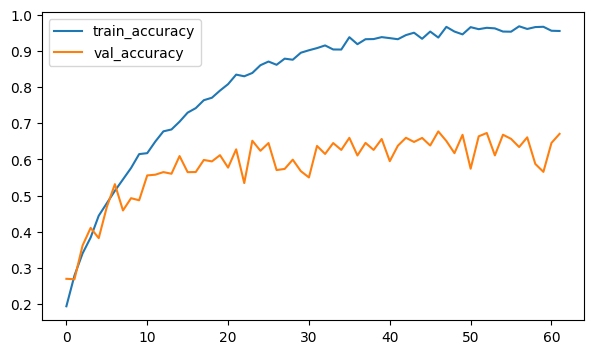

In [83]:
fig, ax = plt.subplots(figsize=(7, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')
# plt.close()

In [84]:
loss_t, acc_t = model8.evaluate(test_set)

313/313 [==============================] - 1s 4ms/step - loss: 1.3849 - accuracy: 0.6670
